In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Other imports.
from lxmls import DATA_PATH
import lxmls.readers.simple_sequence as ssr
import lxmls.sequences.hmm as hmmc
import lxmls.readers.pos_corpus as pcc
import lxmls.sequences.confusion_matrix as cm

# Exercise 3.1
Load the simple sequence dataset. From the ipython command line create a simple sequence object and look at the training and test set.

In [3]:
simple = ssr.SimpleSequence()
print(simple.train)
print(simple.test)

[walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/sunny , walk/sunny shop/sunny shop/sunny clean/sunny ]
[walk/rainy walk/sunny shop/sunny clean/sunny , clean/sunny walk/sunny tennis/sunny walk/sunny ]


In [4]:
simple.train[0].__dict__

{'x': [0, 0, 1, 2],
 'y': [0, 1, 1, 1],
 'nr': 0,
 'sequence_list': [walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/sunny , walk/sunny shop/sunny shop/sunny clean/sunny ]}

In [5]:
for sequence in simple.train.seq_list:
    print(sequence)

walk/rainy walk/sunny shop/sunny clean/sunny 
walk/rainy walk/rainy shop/rainy clean/sunny 
walk/sunny shop/sunny shop/sunny clean/sunny 


In [6]:
for sequence in simple.train.seq_list:
    print(sequence.x)

[0, 0, 1, 2]
[0, 0, 1, 2]
[0, 1, 1, 2]


In [7]:
for sequence in simple.train.seq_list:
    print(sequence.y)

[0, 1, 1, 1]
[0, 0, 0, 1]
[1, 1, 1, 1]


# Exercise 3.2
The provided function train_supervised from the hmm.py file implements the above parameter estimates.
Run this function given the simple dataset above and look at the estimated probabilities. Are they correct? You can also
check the variables ending in counts instead of probs to see the raw counts (for example, typing hmm.initial counts
will show you the raw counts of initial states). How are the counts related to the probabilities?

In [8]:
hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)

In [9]:
print('Initial Counts:', hmm.initial_counts)
print('Transition Counts:\n', hmm.transition_counts)
print('Final Counts:', hmm.final_counts)
print('Emission Counts:\n', hmm.emission_counts)

Initial Counts: [2. 1.]
Transition Counts:
 [[2. 0.]
 [2. 5.]]
Final Counts: [0. 3.]
Emission Counts:
 [[3. 2.]
 [1. 3.]
 [0. 3.]
 [0. 0.]]


In [10]:
print("Initial Probabilities:")
print(hmm.initial_probs)

Initial Probabilities:
[0.66666667 0.33333333]


In [11]:
print("Transition Probabilities:")
print(hmm.transition_probs)

Transition Probabilities:
[[0.5   0.   ]
 [0.5   0.625]]


In [12]:
print("Final Probabilities:")
print(hmm.final_probs)

## sum(p(c_k|c_l) for c_k in states) == 1

# 0.5 + 0.5 + 0. == 1
# 0. + 0.625 + 0.375 == 1

Final Probabilities:
[0.    0.375]


In [13]:
print("Emission Probabilities")
print(hmm.emission_probs)

Emission Probabilities
[[0.75  0.25 ]
 [0.25  0.375]
 [0.    0.375]
 [0.    0.   ]]


# Exercise 3.3 
Convince yourself that the score of a path in the trellis (summing over the scores above) is equivalent to the
log-probability $\log P(X = x, Y = y)$, as defined in **Eq. 3.3**. Use the given function compute_scores on the first training
sequence and confirm that the values are correct. You should get the same values as presented below

In [14]:
initial_scores, transition_scores, final_scores, emission_scores = \
    hmm.compute_scores(simple.train.seq_list[0])
print(initial_scores)

[-0.40546511 -1.09861229]


/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:180: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:178: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:183: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


In [15]:
print(transition_scores)

[[[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]]


In [16]:
print(final_scores)

[       -inf -0.98082925]


In [17]:
print(emission_scores)

[[-0.28768207 -1.38629436]
 [-0.28768207 -1.38629436]
 [-1.38629436 -0.98082925]
 [       -inf -0.98082925]]


# Exercise 3.4 
Look at the module ``sequences/log_domain.py``. This module implements a function ``logsum_pair(logx, logy)`` to add two numbers represented in the log-domain; it returns their sum also represented in the log-domain. The
function logsum(logv) sums all components of an array represented in the log-domain. This will be used later in our
decoding algorithms. To observe why this is important, type the following:

In [18]:
import numpy as np

a = np.random.rand(10)#.astype(np.float64)
print(np.log(sum(np.exp(a))))
print(np.log(sum(np.exp(10*a))))
print(np.log(sum(np.exp(100*a))))
print(np.log(sum(np.exp(1000*a))))

2.7847182192146342
10.071600106017566
95.16689786947194
inf


/Users/andre/Documents/lxmls-toolkit-student/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [19]:
from lxmls.sequences.log_domain import logsum

print(logsum(a))
print(logsum(10*a))
print(logsum(100*a))
print(logsum(1000*a))

2.7847182192146347
10.071600106017566
95.16689786947194
951.6612628834159


# Exercise 3.5 
Run the provided forward-backward algorithm on the first train sequence. Observe that both the forward
and the backward passes give the same log-likelihood.

In [20]:
log_likelihood, forward = hmm.decoder.run_forward(initial_scores, transition_scores, final_scores, emission_scores)
print('Log-Likelihood = {}'.format(log_likelihood))

Log-Likelihood = -5.068232326005127


In [21]:
log_likelihood, backward = hmm.decoder.run_backward(initial_scores, transition_scores, final_scores, emission_scores)
print('Log-Likelihood = {}'.format(log_likelihood))

Log-Likelihood = -5.068232326005126


In [22]:
print(forward, '\n---\n', backward)

[[-0.69314718 -2.48490665]
 [-1.67397643 -2.58334672]
 [-3.75341798 -2.94017562]
 [       -inf -4.08740307]] 
---
 [[-4.41863845 -5.73879301]
 [-3.67819455 -3.88249502]
 [-2.65480569 -2.43166214]
 [       -inf -0.98082925]]


# Exercise 3.6 
Compute the node posteriors for the first training sequence (use the provided compute posteriors function), and look at the output. Note that the state posteriors are a proper probability distribution (the lines of the result
sum to 1)

In [23]:
initial_scores, transition_scores, final_scores, emission_scores = \
    hmm.compute_scores(simple.train.seq_list[0])
state_posteriors, _, _ = hmm.compute_posteriors(initial_scores,
                                                transition_scores,
                                                final_scores,
                                                emission_scores)
print(state_posteriors)

[[0.95738152 0.04261848]
 [0.75281282 0.24718718]
 [0.26184794 0.73815206]
 [0.         1.        ]]


# Exercise 3.7 
Run the posterior decode on the first test sequence, and evaluate it.

In [24]:
y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print("Prediction test 0: {}".format(y_pred))
print("Truth test 0: {}".format(simple.test.seq_list[0]))

Prediction test 0: walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0: walk/rainy walk/sunny shop/sunny clean/sunny 


Do the same for the second test sequence:

In [25]:
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print("Prediction test 1", y_pred)
print("Truth test 1", simple.test.seq_list[1])

Prediction test 1 clean/rainy walk/rainy tennis/rainy walk/rainy 
Truth test 1 clean/sunny walk/sunny tennis/sunny walk/sunny 


/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/sequence_classifier.py:80: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[pos, :] -= log_likelihood
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/sequence_classifier.py:93: RuntimeWarning: invalid value encountered in double_scalars
  transition_posteriors[pos, state, prev_state] -= log_likelihood


What is wrong? Note the observations for the second test sequence: the observation tennis was never seen at
training time, so the probability for it will be zero (no matter what state). This will make all possible state sequences have
zero probability. As seen in the previous lecture, this is a problem with generative models, which can be corrected using
smoothing (among other options).

Change the train supervised method to add smoothing:

    def train_supervised(self,sequence_list, smoothing):
        

In [26]:
hmm.train_supervised(simple.train, smoothing=0.1)

y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print("Prediction test 0 with smoothing")
print(y_pred)
print("Truth test 0")
print(simple.test.seq_list[0])

Prediction test 0 with smoothing
walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0
walk/rainy walk/sunny shop/sunny clean/sunny 


In [27]:
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print("Prediction test 1 with smoothing")
print(y_pred)
print("Truth test 1")
print(simple.test.seq_list[1])

Prediction test 1 with smoothing
clean/sunny walk/sunny tennis/sunny walk/sunny 
Truth test 1
clean/sunny walk/sunny tennis/sunny walk/sunny 


# Exercise 3.8

Implement a method for performing Viterbi decoding in file ``sequence_classification_decoder.py``.

*Hint:* look at the implementation of ``run_forward``. Also check the help for the numpy methods max and argmax.
This method will be called by

``def viterbi_decode(self, sequence)``

in the module ``sequence_classifier.py``.

In [31]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[0])
print("Viterbi decoding Prediction test 0 with smoothing")
print(y_pred, score)
print("Truth test 0")
print(simple.test.seq_list[0])

[[-1 -1]
 [ 0  0]
 [ 0  0]
 [ 0  1]]
> /Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/sequence_classification_decoder.py(121)run_viterbi()
    120         import ipdb; ipdb.set_trace()
--> 121         return path, log_likelihood
    122 

ipdb> c
Viterbi decoding Prediction test 0 with smoothing
walk/rainy walk/rainy shop/sunny clean/sunny  -6.020501246982869
Truth test 0
walk/rainy walk/sunny shop/sunny clean/sunny 


In [32]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[1])
print("Viterbi decoding Prediction test 1 with smoothing")
print(y_pred, score)
print("Truth test 1")
print(simple.test.seq_list[1])

[[-1 -1]
 [ 0  1]
 [ 0  1]
 [ 0  1]]
Viterbi decoding Prediction test 1 with smoothing
clean/sunny walk/sunny tennis/sunny walk/sunny  -11.713974073970887
Truth test 1
clean/sunny walk/sunny tennis/sunny walk/sunny 


# Exercise 3.9 
Test the model using both posterior decoding and Viterbi decoding on both the train and test set, using the
methods in class HMM

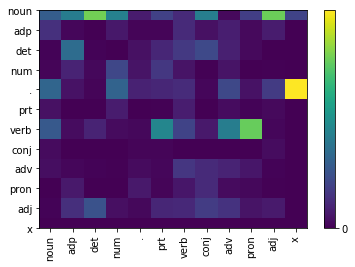

In [33]:
%matplotlib inline

corpus = pcc.PostagCorpus()
train_seq = corpus.read_sequence_list_conll("%s/train-02-21.conll" % DATA_PATH, max_sent_len=15, max_nr_sent=1000)
test_seq = corpus.read_sequence_list_conll("%s/test-23.conll" % DATA_PATH, max_sent_len=15, max_nr_sent=1000)
dev_seq = corpus.read_sequence_list_conll("%s/dev-22.conll" % DATA_PATH, max_sent_len=15, max_nr_sent=1000)
hmm = hmmc.HMM(corpus.word_dict, corpus.tag_dict)
hmm.train_supervised(train_seq)
hmm.print_transition_matrix()

In [34]:
viterbi_pred_train = hmm.viterbi_decode_corpus(train_seq)
posterior_pred_train = hmm.posterior_decode_corpus(train_seq)
eval_viterbi_train = hmm.evaluate_corpus(train_seq, viterbi_pred_train)
eval_posterior_train = hmm.evaluate_corpus(train_seq, posterior_pred_train)
print("Train Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(
eval_posterior_train,eval_viterbi_train))

/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:178: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:180: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/hmm.py:183: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [10 10  8  8  8  8  8 10  8  8  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  5  1  1  1  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  3  3  3  3  3 

 [ 3  3  3  3  3  3  3  3  3  0  3  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  0  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  5  1  1  1  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  1  1  1  1  1  2  0  1  1  2  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 2  2  1  2  2  1  2  0  2  1  2  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10  6  6  6  6  6  6 10  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  5  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10  8  8 10 10  8 10  8  8  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [10  0  0  0  0  0  0 10  0 10 10  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  1  1  1  1  1  2  0  1  1  2  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  1  1  0  0  0  0  0  1  1  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  1  2  0  2  2  2  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  8  8  8  8  8  8  8  8  8  8  0]
 [ 9  9  9  0  9  9  9 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 1  1  1  1  1  1  1  5  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [10  0  0  0  0  0  0 10  0 10 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]]
[[-1 -1 -1 -1 -1 -1 -1 

 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 0  6  6  6  0  6  6  0  6  6  6  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10 10 10 10 10 10 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  5  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [10 10  8  8 10 10  8 10  8  8 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 

Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985


In [35]:
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print("Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f" % (eval_posterior_test, eval_viterbi_test))

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  6  6  0  0  0  0  0  6  6  0]
 [ 1  1  1  1  1  1  1

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 1  1  1  1  1  1  1  0  1  1  1  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4  4  4  4  4  4  4 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  8  8  8  8  8  8  8  8  8  8  0]
 [ 8  8  8  8  8  8  8  8  8  8  8  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [10 10 10 10 10 10 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  0]
 [ 3  3  3  3  3  3  3  3  3  0  3  0]
 [ 0  0  0  0  0  0  

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  0  9  9  9  9  9  9  9  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  0]
 [ 2  2  2  2  2  0  2  0  2  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  7  7  7  0  7  0  7  7  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/sequence_classifier.py:80: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[pos, :] -= log_likelihood
/Users/andre/Documents/lxmls-toolkit-student/lxmls/sequences/sequence_classifier.py:93: RuntimeWarning: invalid value encountered in double_scalars
  transition_posteriors[pos, state, prev_state] -= log_likelihood


Test Set Accuracy: Posterior Decode 0.350, Viterbi Decode: 0.509


In [ ]:
best_smothing = hmm.pick_best_smoothing(train_seq, dev_seq, [10, 1, 0.1, 0])

hmm.train_supervised(train_seq, smoothing=best_smothing)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print("Best Smoothing %f --  Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f" % (best_smothing, eval_posterior_test, eval_viterbi_test))

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  6  6  6  0  6  0  0  6  6  6  4]
 [ 2  0  1  4  0  6  0  0  6  4  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [10  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  0  0  0  6  4  2  0]
 [ 0  0  6  6  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  0  0  0  6  4  2  8]
 [ 1  1  1  1  0  1  0  1  6  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10  0  6 10  0  0  0 10  0 10 10 10]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 0  0  6  4  0  6  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  0  1  3  0  6  0  0  6  4  2  8]
 [ 5  0  5  5  0  5  5  5  5  5  5  5]
 [ 2  6  6  3  0  6  6  0  6  6  6  3]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  8  0  6  4  2  8]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  0  9  0  9  4  2  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 1  0  1  1  0  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  6  8]
 [ 2  0  1  4  0  6  0  0  6  4  2  8]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 6  6  6  6  6  6  6 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  6  6  0  6  8 10  6  6  2  8]
 [ 2  2  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 0  0  0  3  0  0  0  0  0  0  2  0]
 [10  0  6  4  0  6  0  0  6  4  6  4]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  3  0  6  6  0  6  6  6  3]
 [ 2  0  1  3  0  6  0  0  6  6  2  8]
 [ 0  0  6  3  0  0  0  0  6  4  2  3]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  4  4  6  6  4  6  4  6  4]
 [ 2  0  1  3  0  6  9  0  6  6  2  9]
 [ 3  0  6  3  0  3  0  0  6  6  6  3]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  4  4  0  0  0  4  4  4  2  4]
 [ 0  0  6  3  0  0  0  0  6  4  6  9]
 [ 0  0  6  3  0  6  0  0  6  4  6  3]]
[[-1 -1 -1 -1 -1 -1 -1 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  3  0  6  8 10  6  6  2  8]
 [ 0  0  6  3  0  0  0  0  6  6  2  8]
 [ 0  0  6  0  0  0  0  0  0  4  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  6  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0 

 [ 0  0  6  4  0  0  0  0  6  4  2  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  9  4  2  9]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 7  7  7  3  0  7  9  7  7  7  7  7]
 [ 2  0  6  6  0  6  0  0  6  6  2 11]
 [ 4  4  4  4  4  4  0  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  6  4  2  9]
 [ 4  6  4  4  4  6  0  4  4  4  4  4]
 [ 2  0  6  3  0  3  9  0  6  4  2  9]
 [ 0  0  6  6  0  6  0  0  6  6  6  6]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [10  0  6  4  0  6  0  0  6  4  6  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  2]
 [ 0  0  6  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0 10  0 10  2 10]
 [ 0  0  1  1  0  0  0  0  6  4  1  1]
 [ 2  0  6  4  0  6  0  0  6  4  2  4]
 [ 0  0  6  4  0  0  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  1  6  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 0  0  6  4  0  6  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [ 7  0  7  4  0  6  0  7  6  7  7  7]
 [ 2  0  6  4  0  6  0  0  6  4  2 11]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  6  0  6  0  0  6  6  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  0  0  0  0  0  0  4  2  0]
 [ 5  0  5  5  5  5  5  5  6  5  5  5]
 [ 2  6  6  4  4  6  6  4  6  4  6  4]
 [ 2  0  1  3  0  6  9  0  6  6  2  9]
 [ 3  0  6  3  0  3  0  0  6  6  6  3]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  4  4  0  0  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  6  0  0  0  0  6  4  6 10]
 [ 2  2  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  0  1  1  0  6  0  0  6  1  1  1]
 [ 2  0  6  3  0  0  0  0  6  4  2  2]
 [ 1  0  1  1  0  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0  0  0  4  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  7  7  0  0  0  0  7  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  9]
 [ 2  6  6  6  0  6  0  0  6  6  6  8]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  8  4  2  9]
 [ 0  6  6  6  0  6  0  0  6  6  6  9]
 [ 2  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  6  6  6  0  6  0  0  6  6  2  8]
 [ 0  0  1  4  0  0  0  0  6  4  2  8]
 [ 5  0  5  5  5  5  5  5  6  5  5  5]
 [ 2  6  6  3  0  6  6  

 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  3  0  6  6  0  6  6  6  3]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0  0  0  4  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  9  0  0  9  9  9  9  2  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10  0  6 10  0  0  0 10  0 10 10 10]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  1  6  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10  0  6 10  0  0  0 10  0 10 10 10]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 6  6  6  6  6  6  6  5  6  6  6  5]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 0  0  6  6  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  0  0  0  0  0  0  4  0  0]
 [ 1  1  1  1  0  1  0  1  6  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  

 [ 6  6  6  6  6  6  6  0  6  6  6  6]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  0  0  0  0  0  0  4  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  6  0  6  8 10  6  6  2  8]
 [ 0  0  6  8  0  0  0  0  6  6  8  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  1  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7  0  7  7  0  7  0  7  7  7  7  7]
 [ 0  0  6  4  0  0  0  0  6  4  2 11]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  8  8  8  8  8  8  8  8  8  8  8]
 [10  6  6  6  0  6  6 10  6  6  6  6]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  3  6  6  6  0  6  6  6  3]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  8  8  8  8  8  8  8  8  8  8  8]
 [10  6  6  6  6  6  6 10  6  6  6  6]
 [ 2  6  1  1  0  6  8  0  6  6  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  9  9  0  0  9  9  9  9  2  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  8  8  8  8  8  8  8  8  8  8  8]
 [10  6  6  6  6  6  6 10  6  6  6  6]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7  0  7  7  0  7  0  7  7  7  7  7]
 [ 2  0  6  9  0  9  9  9  9  9  2  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  6  6  6  6  6 10  6  6  6  6]
 [ 2  6  6  6  0  6  8  0  6  6  2  8]
 [ 0  0  1  4  0  0  0  0  6  4  2  8]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  2  0  0  0  0  6  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  4 10  0]
 [ 0  0  1  1  0  6  0  0  6  4  6  1]
 [ 2  0  6  4  0  0  0  0  6  4  2  2]
 [ 0  0  6  6  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  9  0  0  7  2  9]
 [ 0  0  6  6  0  6  0  0  6  6  6  6]
 [ 1  0  1  1  0  6  0  0  6  4  1  1]
 [ 2  0  6  4  0  6  0  0  6  4  2  9]
 [ 0  0  1  4  0  0  0  0  6  4  6 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  9]
 [ 2  0  6  6  0  6  0  0  6  6  6  8]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7  0  7  7  0  7  0  7  7  7  7  7]
 [ 4  0  4  4  4  0  0  4  4  4  4  4]
 [ 2  2  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 4  0  4  4  4  4  0  4  4  4  4  4]
 [ 2  0  6  3  0  6  9  0  6  4  2  9]
 [ 0  6  6  6  0  6  0  0  6  6  6  6]
 [ 2  0  1  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  

 [ 0  0  6  0  0  0  0  0  6  6  2  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0  0  0  4  2  2]
 [ 0  0  7  4  0  0  0  0  6  7  7  7]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  4  4  0  0  0  4  4  4  2  4]
 [ 0  0  6  3  0  0  9  0  6  4  2  9]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  6  6  6  0  6  8 10  6  6  2  8]
 [ 0  0  1  1  0  0  9  0  6  6  2  9]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  0  1  1  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  9  0  9  7  2  9]
 [ 0  0  6  6  0  6  0  0  6  6  6  6]
 [ 2  6  6  6  0  6  0  0  6  6  6  8]
 [ 2  0  1  4  0  6  9  0  6  4  2  9]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  6  1  4  0  6  8

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  4  4  0  0  0  4  4  4  2  4]
 [ 0  0  6  3  0  0  9  9  9  9  9  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  6  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  9  0  6  6  2  9]
 [ 2  6  6  2  0  6  2  2  6  6  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  9  4  4  4  4  4]
 [ 2  0  6  3  0  3  9  9  9  4  2  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  9  4  2  2]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  8  8  8  8  8  8  8  8  8  8  8]
 [10  6  6  6  6  6  6 10  6  6  6  8]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  0 10  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  9  0  9  9  2  9]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  6  1  6  0  6  8 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 7  0  7  4  0  6  0  7  6  7  7  7]
 [ 2  0  6  4  0  6  0  0  6  4  2 11]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  4 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 2  0  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  0  1  0  1  6  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  9  4  2  9]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  6  8]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  2  0  6  2  2  6  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  0  1  3  0  3  9  0  9  4  2  9]
 [ 0  0  6  6  0  0  0  0  6  6  6  0]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  7  7  0  0  0  0  7  7  2  7]
 [ 2  0  6  4  0  0  0  0  6  4  2  2]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  0  1  1  0  6  0  0  6  6  2  8]
 [ 0  0  6  4  0  0  0  0  6  4  2  8]
 [ 0  6  6  6  0  6  0  0  6  6  6  4]
 [ 2  0  1  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  0  0  0  6  4  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  1  8  8  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  6  0  0  6  6  6  6]
 [ 2  0  1  4  0  6  0  0  6  4  6  1]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  9  9  3  0  9  9  9  9  9  9  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  6  6  0  6  8 10  6  6  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  6  6  6  0  6  6 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 2  2  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 5  5  5  5  5  5  5  5  5  5  5  5]
 [ 2  6  6  3  0  6  6  0  6  6  6  3]
 [ 2  0  1  3  0  6  0  0  6  6  2  8]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 9  0  9  3  0  9  9  9  9  9  9  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  1  0  0  0  0  0  1  2  7]
 [ 2  0  6  4  0  0  0  0  6  4  2  2]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 4  4  4  4  4  4  4  4  4  4  4  4]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0 

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  4  0  0  0  0  0  4  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 2  0  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  7  4  0  6  0  7  6  7  7  7]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 4  0  4  4  4  6  0  4  4  4  4  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 0  0  6  4  0  0  0  0  6  4  6  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  2]
 [ 0  0  6  0  0  0  0  0  0  4  6  0]
 [ 6  6  6  6  6  6  6 

Smoothing 10.000000 --  Train Set Accuracy: Posterior Decode 0.731, Viterbi Decode: 0.691
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  0  1  0  1  6  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  8]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 2  2  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  9  0  9  7  2  9]
 [ 0  6  6  6  0  6  6  0  6  6  6  6]
 [ 2  8  1  1  8  6  8  8  8  1  8  8]
 [ 2  0  5  5  0  5  5  5  6  5  5  5]
 [ 2  6  6  6  6  6  6  0  6  6  6  3]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 2  0  6  6  0  0  0  0  6  6  2  2]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1 

 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  2 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  8  8  8  8  8  8  8  8  8  8  8]
 [ 2  6  2  2  2  2  2  2  6  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  0  0  6  4  2  5]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 1  0  1  1  0  6  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0  0  0  4  2  2]
 [ 1  0  1  1  0  0  0  0  6  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  2]
 [ 0  0  6  6  0  0  0  0  6  6  6 10]
 [ 0  0  6  4  0  6  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  1  0  0  0  0  0  7  2  7]
 [ 2  0  2  2  0  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [ 7  0  7  4  0  6  0  7  6  7  7  7]
 [ 2  0  6  4  0  6  0  0  6  4  2 11]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  0 10  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 2  0  6  2  0  0  0  0  6  6  2  2]
 [ 0  0  6  4  0  0  0  0  6  4  6 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 1  0  1  1  0  1  0  1  6  1  1  1]
 [ 2  0  6  3  0  0  0  

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  0 10  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 1  1  1  1  1  1  0  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]
 [ 0  0  6  4  0  0  0  0  0  4  6  0]
 [ 7  0  7  4  0  6  0  7  6  7  7  7]
 [ 2  0  6  4  0  6  0  0  6  4  2 11]
 [ 0  0  6  4  0  6  0  0  6  4  2  8]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  2]
 [ 0  0  6  0  0  0  0  0  0  4  6  0]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 2  0  6  4  0  6  8  0  6  4  2  8]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 2  6  1  1  0  6  8 10  6  6  2  8]
 [ 0  0  6  6  0  0  0  0  6  6  2  8]
 [ 1  1  1  1  0  1  0  1  6  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  2  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10  0  6  0  0  0  0  0  0 10 10 10]
 [ 0  0  6  4  0  6  0  0  6  4  6  4]
 [ 0  0  6  4  0  6  0 

Smoothing 10.000000 -- Test Set Accuracy: Posterior Decode 0.712, Viterbi Decode: 0.675
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  7  2  0]
 [ 0  0  1  4  0  0  0  0  6  4  6  4]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  0  1  5  0  6  8  0  6  6  2  8]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  4  0  0  0  0  6  4  6  4]
 [ 0  0  1  4  0  0  0  0  6  4  6  0]
 [10  0  1  4  0  6  0  0  6  4  6  4]
 [ 0  0  0  0  0  0  0  0  0  4  0  0]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  1  3  3  6  8 10  6  6  2  8]
 [ 0  0  6  0  0  0  0  0  0  6  2  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [10 10 10 10 10 10  0 10 10 10 10 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [10  6  1  5

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  0  0  0  0  0  0  7  2  7]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [10  6  6  6  6  6  6 10  6  6  6  6]
 [ 1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  6  0  0  0  0  6  6  6  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 1  6  1  1  8  6  8 10  6  1  1  1]
 [ 0  0  6  3  0  0  0  0  0  6  2  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 6  6  6  6  6  6  6 10  6  6  6  6]
 [ 1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  0  1  3  0  0  0  0  0  4  2  3]
 [ 0  0  6  6  0  6  0  0  6  6  6  0]
 [ 3  0  1  3  0  6  0  0  6  4  2  3]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  2]
 [ 0  0  0  0  0  0  0

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9  9  9  9  9  9  9  9  9  9  9  9]
 [ 6  6  6  6  6  6  6  6  6  6  6  6]
 [ 8  8  8  8  8  8  8  8  8  8  8  8]
 [10  6  6  6 10  6  6 10  6  6  6 10]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9  9  9  9  9  9  9  9  9  9  9  9]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  8  1  8  8  6  8 10  8  6  8  8]
 [10 10  8  8 10 10  8 10  8  8  8 10]
 [ 1  1  1  1  1  0  1  0  1  1  1  1]
 [ 2  0  8  3  0  0  0  0  0  4  2  2]
 [10 10  1 10 10 10  0 10  6 10 10 10]
 [ 0  0  1  0  0  0  0  0  0  4  0  0]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  1  2  0  0  0  0  0  7  2  7]
 [ 0  0  1  4  0  0  0  0  6  4  6  9]
 [ 6  6  6  6  6  6  6  0  6  6  6  6]
 [ 2  6  2  2  2  6  2  2  2  2  2  2]
 [ 0  0  6  0  0  0  0  0  0  6 10  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  4  0  0  0  0  6  4  6  4]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  0  2  2  0  0  2  0  2  2  2  2]
 [ 0  0  6  0  0  0  0

In [ ]:
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test,
                                             len(corpus.tag_dict), hmm.get_num_states())

cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict,
                            range(hmm.get_num_states()), 'Confusion matrix')


# Exercice 3.10
Implement the method to update the counts given the state and transition posteriors

```
def update_counts(self, sequence, state_posteriors, transition_posteriors):
```

Look at the code for EM algorithm in file ```sequences/hmm.py``` and check it for yourself.

# Exercise 3.11
Run 20 epochs of the EM algorithm for part of speech induction:

In [ ]:
# Train with EM.
hmm.train_EM(train_seq, 0.1, 20, evaluate=True)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)

In [ ]:
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test,
                                             len(corpus.tag_dict), hmm.get_num_states())
cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict,
                            range(hmm.get_num_states()), 'Confusion matrix')